<div style="display: block; height:200px; overflow:hidden;position: relative">
     <img src="https://imgur.com/cSyszHt.jpg" style="position: absolute;top: -250px;">
</div>

<div style="text-align:center; font-size: 30pt; font-weight:700">Rain in Australia</div>

<i>- March 22nd 2021 -</i>
<div>I am new in datascience and I am currently attending the <a href="https://www.lewagon.com/">Le Wagon data science bootcamp</a> in Paris. This is my first notebook on Kaggle ðŸ™‚</div>
<div>The goal is to train a model that could predict rain tomorrow in Australia, for this analysis a simple LogisticRegression model is used.</div>
<br>
<b>
<ol >
    <li>
        <b>Imports</b>
    </li>
    <li>
        <b>Loading dataset</b>
    </li>
    <li>
        <b>Checking duplicates</b>
    </li>
    <li>
        <b>Removing lines with NaN in RainTomorrow and RainToday</b>
    </li>
    <li>
        <b>Features editing</b>
    </li>
    <li>
        <b>Some simple visualizations</b>
    </li>
    <li>
        <b>Encoding</b>
    </li>
    <li>
        <b>Feature / target preparation</b>
    </li>
    <li>
        <b>Remove highly correlated features</b>
    </li>
    <li>
        <b>Low importance features removal with permutation importance</b>
    </li>
    <li>
        <b>Model evaluation</b>
    </li>
</ol>
    </b>
<br>
<div>For a better readability of the notebook, I put the dataviz code inside an attached file instead of directly inside here. Indeed this code is messy and is not the subject of the analysis.</div><br>
<div>Please feel free to comment, any feedback to improve this work / fix mistakes is welcome.</div>

# 1. Imports

In [6]:
import warnings
warnings.filterwarnings('ignore')
#
from scipy import stats
#import rain_australia_scripts
import pandas as pd
import folium
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from geopy.geocoders import Nominatim
from ipywidgets import interact
import matplotlib.pyplot as plt
import calendar
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import precision_recall_curve
from folium.plugins import HeatMap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_selector
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-white');
plt.rcParams['font.size'] = 14;
plt.figure(figsize=(12,5));
palette = sns.color_palette('Paired', 10);
from sklearn import set_config; set_config(display='diagram')

<Figure size 864x360 with 0 Axes>

In [7]:
data = pd.read_csv("weatherAUS.csv")
data.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0           W           44.0          W        WNW          20.0   
1         WNW           44.0        NNW        WSW           4.0   
2         WSW           46.0          W        WSW          19.0   
3          NE           24.0         SE          E          11.0   
4           W           41.0        ENE         NW           7.0   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
0          24.0         71.0         22.0       1007.7       1007.1       8.0   
1          22.0         44.0         25.0       1010.6       1007.8       NaN   
2          26.0         38.0         30.0       1007.6       1008.7       NaN   
3           9.0         45.0         16.0       1017.6       1012.8       NaN   
4          20.0         82.0         33.0       1010.8       1006.0       7.0   

   Cloud3pm  Temp9am  Temp3pm RainToday RainTomorrow  
0       NaN     16.9     21.8        No           No  
1       NaN     17.2     24.3        No           No  
2       2.0     21.0     23.2        No           No  
3       NaN     18.1     26.5        No           No  
4       8.0     17.8     29.7        No           No

# 2. Duplicates

In [5]:
size_before = len(data)
data = data.drop_duplicates()
size_after = len(data)
print(str(size_before - size_after) + " duplicates were removed.")

0 duplicates were removed.


# 3. Missing
<div style="font-weight:700">Dropping features that have too many missing values</div>

In [6]:
100 * data.isnull().sum().sort_values(ascending=False)/len(data)

Sunshine         48.009762
Evaporation      43.166506
Cloud3pm         40.807095
Cloud9am         38.421559
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
Temp9am           1.214767
WindSpeed9am      1.214767
MinTemp           1.020899
MaxTemp           0.866905
Location          0.000000
Date              0.000000
dtype: float64

<div style="font-weight:700">Let's remove features with more than 30% missing values:</div>
<br/>
<div style="font-weight:700">> <span style="color:royalblue">Sunshine</span>, <span style="color:royalblue">Evaporation</span>, <span style="color:royalblue">Cloud3pm</span>, <span style="color:royalblue">Cloud9am</span></div>

In [7]:
data = data.drop(["Sunshine", "Evaporation", "Cloud3pm", "Cloud9am"], axis=1)

In [8]:
data.head()

Date Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed  \
0  2008-12-01   Albury     13.4     22.9       0.6           W           44.0   
1  2008-12-02   Albury      7.4     25.1       0.0         WNW           44.0   
2  2008-12-03   Albury     12.9     25.7       0.0         WSW           46.0   
3  2008-12-04   Albury      9.2     28.0       0.0          NE           24.0   
4  2008-12-05   Albury     17.5     32.3       1.0           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          W        WNW          20.0          24.0         71.0         22.0   
1        NNW        WSW           4.0          22.0         44.0         25.0   
2          W        WSW          19.0          26.0         38.0         30.0   
3         SE          E          11.0           9.0         45.0         16.0   
4        ENE         NW           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm RainToday RainTomorrow  
0       1007.7       1007.1     16.9     21.8        No           No  
1       1010.6       1007.8     17.2     24.3        No           No  
2       1007.6       1008.7     21.0     23.2        No           No  
3       1017.6       1012.8     18.1     26.5        No           No  
4       1010.8       1006.0     17.8     29.7        No           No

# 4. Coordinates
<br/>
<div style="font-weight:700">To retrieve correct coordinates with Nominatim, we need cities name to be correctly written</div>

In [9]:
badly_named = {"AliceSprings":"Alice Springs",
               "BadgerysCreek":"Badgerys Creek",
               "CoffsHarbour": "Coffs Harbour",
               "GoldCoast": "Gold Coast",
               "MelbourneAirport": "Melbourne Airport",
               "MountGambier": "Mount Gambier",
               "MountGinini": "Mount Ginini",
               "NorahHead": "Norah Head",
               "NorfolkIsland": "Norfolk Island",
               "PearceRAAF": "Pearce RAAF",
               "PerthAirport": "Perth Airport",
               "SalmonGums": "Salmon Gums",
               "SydneyAirport": "Sydney Airport",
               "WaggaWagga": "Wagga Wagga"}
data["Location"] = data["Location"].apply(lambda x: badly_named[x] if x in badly_named.keys() else x)

In [10]:
geolocator = Nominatim(user_agent="null")
#
latitude = []
longitude = []
#
for k in data["Location"].unique():
    search_ = k + ", Australia"
    location = geolocator.geocode(search_)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
#
latitude = dict(zip(data["Location"].unique(), latitude))
longitude = dict(zip(data["Location"].unique(), longitude))

In [11]:
data["longitude"] = data["Location"].map(longitude)
data["latitude"] = data["Location"].map(latitude)

# 4. Explore Data

In [12]:
center_location = [-25.3455545, 131.036961]
m = folium.Map(location=center_location, control_scale=True, zoom_start=4)#, tiles="Stamen terrain")

In [13]:
heatmap_data = data[['latitude', 'longitude', 'Rainfall']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=15, gradient=gradient, max_zoom=1).add_to(m)
m

In [14]:
def barplot_rainTomorrow(df):
    df.sort_values(by="Location", inplace=True)
    ax = sns.displot(data=df,x="Location", hue="RainTomorrow",multiple="stack", aspect=2.2, height=7, legend=False);
    plt.tick_params(axis='y', rotation=0, size=10, labelsize=18)
    plt.xlabel("", fontdict={"fontsize":25})
    plt.ylabel("Days", fontdict={"fontsize":25}, loc="bottom")
    plt.tick_params(axis='x', rotation=90, size=20, labelsize=20, top=False)
    plt.tick_params(axis='y', right=False)
    plt.legend(["Yes","No"], title="Rain Tomorrow", title_fontsize=20, fontsize=20, loc='right', bbox_to_anchor=(1.05, 1));
    plt.title("Days of Rain Tomorrow per city \n over the covered period", fontsize=30);

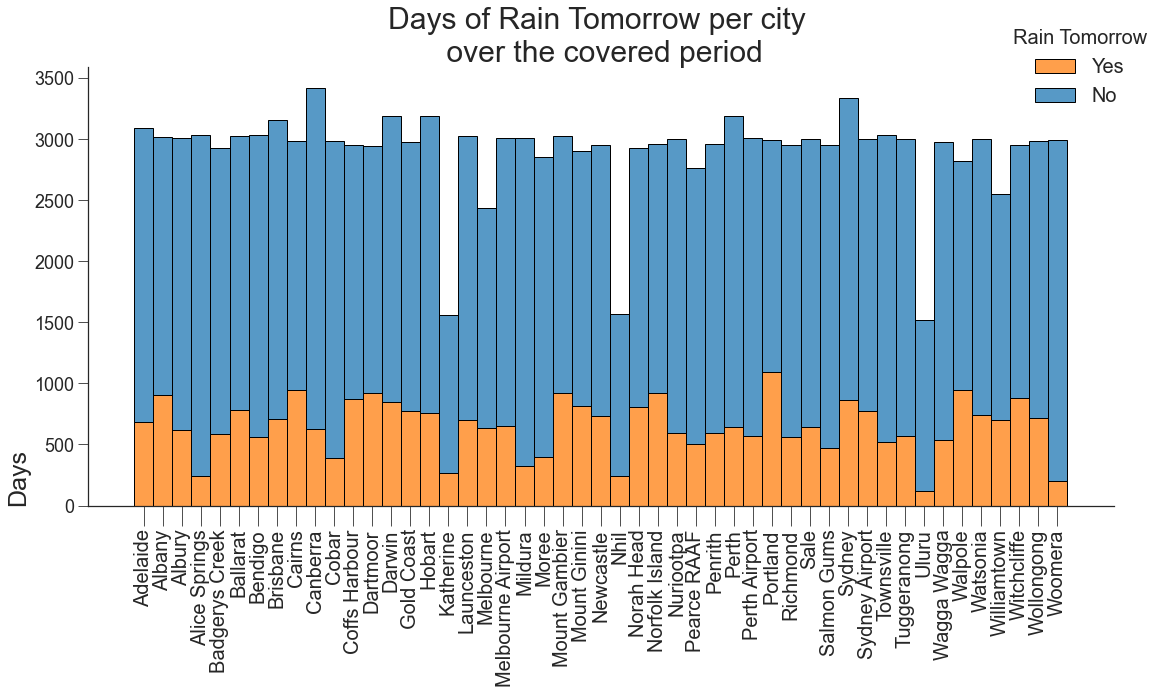

In [15]:
barplot_rainTomorrow(data)

In [16]:
data["Date"] = pd.to_datetime(data["Date"])
data["Month"] = data["Date"].apply(lambda x: x.month)

In [17]:
@interact
def plot_climate(city=sorted(list(data.Location.unique()))):
    #def plot_climate_script(data, city=city):
    df = data.copy()
    rainfall = df.groupby(["Location", "Month"])[["Rainfall"]].mean()
    max_temp = df.groupby(["Location", "Month"])[["MaxTemp"]].mean()
    max_tempMin = df.groupby(["Location", "Month"])[["MaxTemp"]].min()
    max_tempMax = df.groupby(["Location", "Month"])[["MaxTemp"]].max()
    min_temp = df.groupby(["Location", "Month"])[["MinTemp"]].mean()
    min_tempMin = df.groupby(["Location", "Month"])[["MinTemp"]].min()
    min_tempMax = df.groupby(["Location", "Month"])[["MinTemp"]].max()
    
    fig, ax1 = plt.subplots(figsize=(13,7))
    ax2 = ax1.twinx()
    ax2.plot(max_temp.unstack()["MaxTemp"].T[city], 'o-', color="red", linewidth=3, markersize=12, label="Avg max temp")
    ax2.plot(max_tempMin.unstack()["MaxTemp"].T[city], 'o-', color="orangered", linewidth=1, markersize=5, alpha=0.3)
    ax2.plot(max_tempMax.unstack()["MaxTemp"].T[city], 'o-', color="orangered", linewidth=1, markersize=5, alpha=0.3)
    ax2.fill_between(np.arange(1, 13),
                     max_tempMin.unstack()["MaxTemp"].T[city],
                     max_tempMax.unstack()["MaxTemp"].T[city],
                     color="orangered",
                     alpha=0.1,
                     label="Max temp range")
    ax2.plot(min_temp.unstack()["MinTemp"].T[city], 'o-', color="blue", linewidth=3, markersize=12, label="Avg min temp")
    ax2.plot(min_tempMin.unstack()["MinTemp"].T[city], 'o-', color="darkblue", linewidth=1, markersize=5, alpha=0.3)
    ax2.plot(min_tempMax.unstack()["MinTemp"].T[city], 'o-', color="darkblue", linewidth=1, markersize=5, alpha=0.3)
    ax2.fill_between(np.arange(1, 13),
                     min_tempMin.unstack()["MinTemp"].T[city],
                     min_tempMax.unstack()["MinTemp"].T[city],
                     color="darkblue",
                     alpha=0.1,
                     label="Min temp range")
    ax2.tick_params(axis='y', size=5, labelsize=13)
    ax2.set_ylabel('Temperature [Â°C]', fontsize=15, labelpad=15)
    ax2.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    
    ax1.bar(x= np.arange(1, 13), height=rainfall.unstack()["Rainfall"].T[city], label="Avg monthly rainfall")
    plt.xticks(list(rainfall.unstack()["Rainfall"].columns),
               list(pd.Series(rainfall.unstack()["Rainfall"].columns).apply(lambda x: calendar.month_name[x])))
    ax1.tick_params(axis='x', rotation=45, size=13, labelsize=13, top=False)
    ax1.tick_params(axis='y', size=5, labelsize=13)
    ax1.set_ylabel('Average monthly rainfall [mm]', fontsize=15, labelpad=15)
    ax1.set_title(f"{city}, South Australia", pad=20, fontdict={"fontsize":30, "color":"black"})
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.legend(title='', bbox_to_anchor=(1.05, 1.0), loc='lower left')
    plt.tight_layout()

interactive(children=(Dropdown(description='city', options=('Adelaide', 'Albany', 'Albury', 'Alice Springs', 'â€¦

In [18]:
data.head()

Date  Location  MinTemp  MaxTemp  Rainfall WindGustDir  \
96988 2010-04-30  Adelaide     10.8     21.2       0.0         ENE   
98443 2014-07-22  Adelaide      3.7     19.0       0.0           N   
98444 2014-07-23  Adelaide      9.6     15.8       0.0          NE   
98445 2014-07-24  Adelaide     10.1     15.5      16.6         NNE   
98446 2014-07-25  Adelaide     11.2     16.2       1.8          NW   

       WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  \
96988           22.0        ENE         NW           9.0           7.0   
98443           24.0        NaN        NNE           0.0          11.0   
98444           52.0        NNE         NE           9.0          20.0   
98445           50.0         NW         NW          17.0          26.0   
98446           30.0        WNW        WNW          13.0          15.0   

       Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
96988         66.0         48.0       1028.4       1024.7     15.7     21.0   
98443         75.0         32.0       1024.2       1021.1      9.6     18.5   
98444         35.0         51.0       1017.9       1011.5     14.7     15.4   
98445         96.0         80.0       1007.4       1008.0     11.2     14.0   
98446         89.0         70.0       1018.4       1019.2     13.0     15.3   

      RainToday RainTomorrow   longitude   latitude  Month  
96988        No           No  138.599931 -34.928181      4  
98443        No           No  138.599931 -34.928181      7  
98444        No          Yes  138.599931 -34.928181      7  
98445       Yes          Yes  138.599931 -34.928181      7  
98446       Yes          Yes  138.599931 -34.928181      7

# 5. Training

## 5.1. Dataset preparation

## 5.2. Clean data
<br/>
<div style="font-weight:700">Let's first remove features we had for exploration and that won't be usefull then</div> <ul><li><span style="color:royalblue">latitude</span>, <span style="color:royalblue">longitude</span>: because we have the feature <span style="color:royalblue">Location</span></li><li><span style="color:royalblue">Date</span>: because we have the feature <span style="color:royalblue">Month</span></li></ul>

In [19]:
data = data.drop(["Date", "longitude", "latitude"], axis=1).reset_index(drop=True)

In [20]:
def clean_data(df):
    df = df[(~df["RainTomorrow"].isnull())]
    df = df[(~df["RainToday"].isnull())]
    df["Month"] = df["Month"].apply(lambda x: calendar.month_name[x])
    df["RainTomorrow"] = df["RainTomorrow"].apply(lambda x: 1 if x=="Yes" else 0)
    df["RainToday"] = df["RainToday"].apply(lambda x: 1 if x=="Yes" else 0)
    return df
#
data = clean_data(data)

In [21]:
data["MinTemp"].max()

33.9

<div style="font-weight:700">Model inputs:</div>

In [22]:
X_train = data.drop(["RainTomorrow"], axis=1).copy()
y_train = data["RainTomorrow"].copy()

In [23]:
X_train.head()

Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed WindDir9am  \
0  Adelaide     10.8     21.2       0.0         ENE           22.0        ENE   
1  Adelaide      3.7     19.0       0.0           N           24.0        NaN   
2  Adelaide      9.6     15.8       0.0          NE           52.0        NNE   
3  Adelaide     10.1     15.5      16.6         NNE           50.0         NW   
4  Adelaide     11.2     16.2       1.8          NW           30.0        WNW   

  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0         NW           9.0           7.0         66.0         48.0   
1        NNE           0.0          11.0         75.0         32.0   
2         NE           9.0          20.0         35.0         51.0   
3         NW          17.0          26.0         96.0         80.0   
4        WNW          13.0          15.0         89.0         70.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  Month  
0       1028.4       1024.7     15.7     21.0          0  April  
1       1024.2       1021.1      9.6     18.5          0   July  
2       1017.9       1011.5     14.7     15.4          0   July  
3       1007.4       1008.0     11.2     14.0          1   July  
4       1018.4       1019.2     13.0     15.3          1   July

## 5.3. Pipelines

### 5.3.1. Pipeline for numeric features
<br/>
<div style="font-weight:700">Let's define <span style="color:green; font-variant:small-caps">mean</span> as the default impute strategy</div>

In [24]:
pipe_numeric = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean'))
])
pipe_numeric

Pipeline(steps=[('imputer', SimpleImputer())])

### 5.3.2. Pipeline for binary features

In [25]:
pipe_binary = Pipeline([
    ('encoder', OneHotEncoder(sparse=False, drop='if_binary'))
])
pipe_binary

Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary', sparse=False))])

### 5.3.3. Pipeline for multiclass features
<br/>
<div style="font-weight:700">Let's define <span style="color:green; font-variant:small-caps">most frequent</span> as the default impute strategy</div>

In [26]:
pipe_multiclass = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(sparse=False, handle_unknown="ignore"))
])
pipe_multiclass

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

### 5.3.34. Impute and encode pipeline combination

In [27]:
impute_and_encode = ColumnTransformer([
    ('numeric', pipe_numeric, make_column_selector(dtype_include="float64")),
    ('binary', pipe_binary, make_column_selector(dtype_include="int64")),
    ('multiclass', pipe_multiclass, make_column_selector(dtype_include="object"))])
impute_and_encode

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17a2277f0>),
                                ('binary',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17a227760>),
                                ('multiclass',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17a227850>)])

### 5.3.5. Preprocessor pipeline
<br/>
<div style="font-weight:700">Let's define <span style="color:green; font-variant:small-caps">StandardScaler()</span> as the default scaler</div>

In [28]:
preprocessor = Pipeline([("preproc", impute_and_encode), 
                         ("scaler", StandardScaler())])

<div style="font-weight:700">Overview of the preprocessor pipeline output:</div>

In [29]:
preprocessor.fit(X_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17a2277f0>),
                                                 ('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17a227760>),
                                                 ('multiclass',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17a227850>)])),
                ('scaler', StandardScaler())])

<div style="font-weight:700">The output columns will be in the order of appearance in the ColumnTranformer pipe:</div>

In [30]:
def def_col_names(a, colnames):
    col_names = []
    for k in colnames:
        col_names.append(a + "_" + str(k))
    return col_names

In [31]:
output_pipe_columns = list(X_train[make_column_selector(dtype_include="float64")].columns)
#
output_pipe_columns += list(X_train[make_column_selector(dtype_include="int64")].columns)
#
for k in list(X_train[make_column_selector(dtype_include="object")].columns):
    output_pipe_columns += def_col_names(k, X_train[k].dropna().unique())

In [32]:
X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X_train), columns=output_pipe_columns)
X_train_scaled.head()

MinTemp   MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0 -0.216609 -0.286366 -0.277606      -1.368479     -0.563718     -1.334057   
1 -1.327163 -0.595932 -0.277606      -1.216176     -1.580343     -0.875269   
2 -0.404308 -1.046211 -0.277606       0.916061     -0.563718      0.157004   
3 -0.326100 -1.088424  1.683377       0.763758      0.339949      0.845186   
4 -0.154042 -0.989926 -0.064969      -0.759268     -0.111885     -0.416481   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm   Temp9am   Temp3pm  \
0    -0.149090    -0.167874     1.592111     1.412949 -0.198596 -0.100859   
1     0.325579    -0.946580     0.969812     0.874229 -1.139832 -0.464611   
2    -1.784059    -0.021866     0.036363    -0.562359 -0.352897 -0.915665   
3     1.433139     1.389539    -1.519385    -1.086114 -0.892950 -1.119366   
4     1.063952     0.902847     0.110447     0.589904 -0.615209 -0.930215   

   RainToday  Location_Adelaide  Location_Albany  Location_Albury  \
0  -0.536378           6.754126        -0.147455         -0.14733   
1  -0.536378           6.754126        -0.147455         -0.14733   
2  -0.536378           6.754126        -0.147455         -0.14733   
3   1.864356           6.754126        -0.147455         -0.14733   
4   1.864356           6.754126        -0.147455         -0.14733   

   Location_Alice Springs  Location_Badgerys Creek  Location_Ballarat  \
0               -0.148183                -0.144435          -0.147982   
1               -0.148183                -0.144435          -0.147982   
2               -0.148183                -0.144435          -0.147982   
3               -0.148183                -0.144435          -0.147982   
4               -0.148183                -0.144435          -0.147982   

   Location_Bendigo  Location_Brisbane  Location_Cairns  Location_Canberra  \
0         -0.148308          -0.150839        -0.146649          -0.157361   
1         -0.148308          -0.150839        -0.146649          -0.157361   
2         -0.148308          -0.150839        -0.146649          -0.157361   
3         -0.148308          -0.150839        -0.146649          -0.157361   
4         -0.148308          -0.150839        -0.146649          -0.157361   

   Location_Cobar  Location_Coffs Harbour  Location_Dartmoor  Location_Darwin  \
0       -0.147053               -0.146041          -0.146016        -0.152311   
1       -0.147053               -0.146041          -0.146016        -0.152311   
2       -0.147053               -0.146041          -0.146016        -0.152311   
3       -0.147053               -0.146041          -0.146016        -0.152311   
4       -0.147053               -0.146041          -0.146016        -0.152311   

   Location_Gold Coast  Location_Hobart  Location_Katherine  \
0            -0.145635        -0.152091           -0.105337   
1            -0.145635        -0.152091           -0.105337   
2            -0.145635        -0.152091           -0.105337   
3            -0.145635        -0.152091           -0.105337   
4            -0.145635        -0.152091           -0.105337   

   Location_Launceston  Location_Melbourne  Location_Melbourne Airport  \
0            -0.148058           -0.128815                   -0.147782   
1            -0.148058           -0.128815                   -0.147782   
2            -0.148058           -0.128815                   -0.147782   
3            -0.148058           -0.128815                   -0.147782   
4            -0.148058           -0.128815                   -0.147782   

   Location_Mildura  Location_Moree  Location_Mount Gambier  \
0         -0.147681       -0.142215               -0.148108   
1         -0.147681       -0.142215               -0.148108   
2         -0.147681       -0.142215               -0.148108   
3         -0.147681       -0.142215               -0.148108   
4         -0.147681       -0.142215               -0.148108   

   Location_Mount Ginini  Location_Newcastle  Location_Nhil

## 5.3.6. Final Pipeline
<br/>
<div style="font-weight:700">Let's add a baseline model - <span style="color:green; font-variant:small-caps">RandomForestClassifier()</span> - to the pipeline as the default model</div>

In [33]:
final_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ('classifier', LogisticRegression(max_iter=10000))])#RandomForestClassifier()
final_pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preproc',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x17a2277f0>),
                                                                  ('binary',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OneHotEncoder(drop='if_binary',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x17a227760>),
                                                                  ('multiclass',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x17a227850>)])),
                                 ('scaler', StandardScaler())])),
                ('classifier', LogisticRegression(max_iter=10000))])

# 6. Baseline performance with a LogisticRegression classifier

## 6.1. Baseline accuracy score

In [34]:
cv_baseline_LR = cross_validate(final_pipe, X_train, y_train, scoring= "recall", cv=10)
print("Baseline recall score for LogisticRegression: " + str(round(cv_baseline_LR["test_score"].mean()*100, 2)) + "%")

Baseline recall score for LogisticRegression: 50.59%


## 6.2. Baseline confusion matrix

In [35]:
prediction_dataFrame = pd.DataFrame(y_train).copy()
prediction_dataFrame['predictions'] = cross_val_predict(estimator=final_pipe,
                                                        X=X_train,
                                                        y=y_train,
                                                        cv=10)

In [36]:
prediction_dataFrame.columns = ["y_true", "y_pred"]
prediction_dataFrame.head()

y_true  y_pred
0       0       0
1       0       0
2       1       0
3       1       1
4       1       0

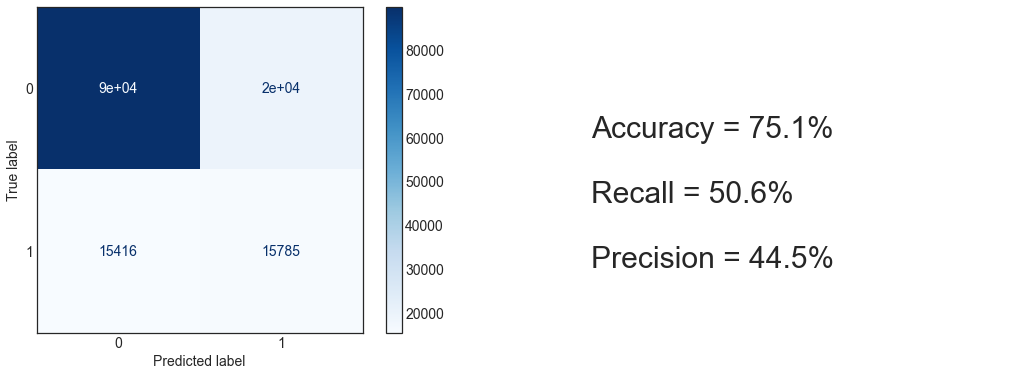

In [37]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(prediction_dataFrame["y_true"], prediction_dataFrame["y_pred"]))
disp.plot(cmap="Blues", ax=ax1);
ax2 = fig.add_subplot(gs[0, 1])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
#
ax2.text(0.1, 0.6, 'Accuracy = '+ str(round(accuracy_score(prediction_dataFrame["y_true"],
                                                           prediction_dataFrame["y_pred"])*100, 1)) + "%",
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.4, 'Recall = '+ str(round(recall_score(prediction_dataFrame["y_true"], 
                                                       prediction_dataFrame["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.2, 'Precision = '+ str(round(precision_score(prediction_dataFrame["y_true"], 
                                                             prediction_dataFrame["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});

# 7. Model optimization

## 7.1. Pearson Correlation
<br/>
<div style="font-weight:700">Let's see which features are redundants</div>

In [38]:
X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X_train), columns=output_pipe_columns)
X_train_scaled.head()

MinTemp   MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0 -0.216609 -0.286366 -0.277606      -1.368479     -0.563718     -1.334057   
1 -1.327163 -0.595932 -0.277606      -1.216176     -1.580343     -0.875269   
2 -0.404308 -1.046211 -0.277606       0.916061     -0.563718      0.157004   
3 -0.326100 -1.088424  1.683377       0.763758      0.339949      0.845186   
4 -0.154042 -0.989926 -0.064969      -0.759268     -0.111885     -0.416481   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm   Temp9am   Temp3pm  \
0    -0.149090    -0.167874     1.592111     1.412949 -0.198596 -0.100859   
1     0.325579    -0.946580     0.969812     0.874229 -1.139832 -0.464611   
2    -1.784059    -0.021866     0.036363    -0.562359 -0.352897 -0.915665   
3     1.433139     1.389539    -1.519385    -1.086114 -0.892950 -1.119366   
4     1.063952     0.902847     0.110447     0.589904 -0.615209 -0.930215   

   RainToday  Location_Adelaide  Location_Albany  Location_Albury  \
0  -0.536378           6.754126        -0.147455         -0.14733   
1  -0.536378           6.754126        -0.147455         -0.14733   
2  -0.536378           6.754126        -0.147455         -0.14733   
3   1.864356           6.754126        -0.147455         -0.14733   
4   1.864356           6.754126        -0.147455         -0.14733   

   Location_Alice Springs  Location_Badgerys Creek  Location_Ballarat  \
0               -0.148183                -0.144435          -0.147982   
1               -0.148183                -0.144435          -0.147982   
2               -0.148183                -0.144435          -0.147982   
3               -0.148183                -0.144435          -0.147982   
4               -0.148183                -0.144435          -0.147982   

   Location_Bendigo  Location_Brisbane  Location_Cairns  Location_Canberra  \
0         -0.148308          -0.150839        -0.146649          -0.157361   
1         -0.148308          -0.150839        -0.146649          -0.157361   
2         -0.148308          -0.150839        -0.146649          -0.157361   
3         -0.148308          -0.150839        -0.146649          -0.157361   
4         -0.148308          -0.150839        -0.146649          -0.157361   

   Location_Cobar  Location_Coffs Harbour  Location_Dartmoor  Location_Darwin  \
0       -0.147053               -0.146041          -0.146016        -0.152311   
1       -0.147053               -0.146041          -0.146016        -0.152311   
2       -0.147053               -0.146041          -0.146016        -0.152311   
3       -0.147053               -0.146041          -0.146016        -0.152311   
4       -0.147053               -0.146041          -0.146016        -0.152311   

   Location_Gold Coast  Location_Hobart  Location_Katherine  \
0            -0.145635        -0.152091           -0.105337   
1            -0.145635        -0.152091           -0.105337   
2            -0.145635        -0.152091           -0.105337   
3            -0.145635        -0.152091           -0.105337   
4            -0.145635        -0.152091           -0.105337   

   Location_Launceston  Location_Melbourne  Location_Melbourne Airport  \
0            -0.148058           -0.128815                   -0.147782   
1            -0.148058           -0.128815                   -0.147782   
2            -0.148058           -0.128815                   -0.147782   
3            -0.148058           -0.128815                   -0.147782   
4            -0.148058           -0.128815                   -0.147782   

   Location_Mildura  Location_Moree  Location_Mount Gambier  \
0         -0.147681       -0.142215               -0.148108   
1         -0.147681       -0.142215               -0.148108   
2         -0.147681       -0.142215               -0.148108   
3         -0.147681       -0.142215               -0.148108   
4         -0.147681       -0.142215               -0.148108   

   Location_Mount Ginini  Location_Newcastle  Location_Nhil

In [39]:
corr_df = X_train_scaled.corr().unstack().reset_index()
corr_df.columns = ['feature_1','feature_2', 'correlation']
corr_df.sort_values(by="correlation",ascending=False, inplace=True)
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']]
corr_df = corr_df.reset_index(drop=True)
corr_df.head()

feature_1    feature_2  correlation
0      Temp3pm      MaxTemp     0.970337
1      MaxTemp      Temp3pm     0.970337
2  Pressure3pm  Pressure9am     0.960051
3  Pressure9am  Pressure3pm     0.960051
4      MinTemp      Temp9am     0.898945

<div style="font-weight:700">We remove features which have a high correlation coefficient ( above 0.9 or below -0.9 )</div>

In [40]:
high_correlation_coeff = corr_df[(corr_df["correlation"]>0.9) | (corr_df["correlation"]<-0.9)]
high_correlation_coeff

feature_1    feature_2  correlation
0      Temp3pm      MaxTemp     0.970337
1      MaxTemp      Temp3pm     0.970337
2  Pressure3pm  Pressure9am     0.960051
3  Pressure9am  Pressure3pm     0.960051

In [41]:
X_train.drop(["Temp3pm"], axis=1, inplace=True)
X_train.drop(["Pressure3pm"], axis=1, inplace=True)

## 7.2. Randomized search cv for an optimized model
<br/>
<div style="font-weight:700">We want to see if we can increase the recall score to capture more of the minority class, that is to say days with rain tomorrow</div>

### 7.2.1. Best baseline model
<br/>
<div style="font-weight:700">What is the model providing the best recall score with its default parameters</div>

In [42]:
grid_model = {'classifier': [RandomForestClassifier(), 
                             LogisticRegression(max_iter=10000), 
                             GradientBoostingClassifier(),
                             DecisionTreeClassifier(),
                             LinearSVC()],
              "preprocessor__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]
             }

search_model = RandomizedSearchCV(final_pipe,
                                  grid_model,
                                  scoring="recall",
                                  n_iter=20,
                                  cv=5,
                                  n_jobs=-1,
                                  verbose=True)
search_model.fit(X_train, y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [43]:
search_model.best_params_

{'preprocessor__scaler': MinMaxScaler(),
 'classifier': DecisionTreeClassifier()}

In [44]:
search_model.best_score_

0.5184756151422151

In [45]:
pred_best_model = pd.DataFrame(y_train).copy()
pred_best_model['predictions'] = cross_val_predict(estimator=search_model.best_estimator_,
                                                   X=X_train,
                                                   y=y_train,
                                                   cv=5)
pred_best_model.columns = ["y_true", "y_pred"]

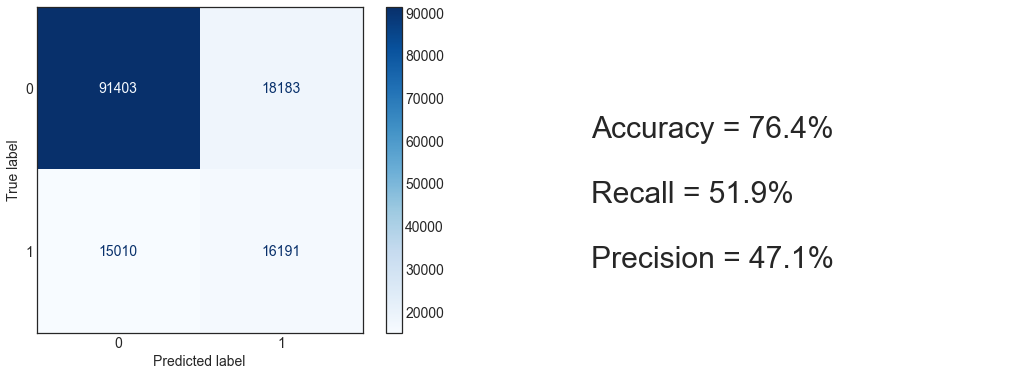

In [46]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_best_model["y_true"], pred_best_model["y_pred"]))
disp.plot(cmap="Blues", ax=ax1);
ax2 = fig.add_subplot(gs[0, 1])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
#
ax2.text(0.1, 0.6, 'Accuracy = '+ str(round(accuracy_score(pred_best_model["y_true"],
                                                           pred_best_model["y_pred"])*100, 1)) + "%",
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.4, 'Recall = '+ str(round(recall_score(pred_best_model["y_true"], 
                                                       pred_best_model["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.2, 'Precision = '+ str(round(precision_score(pred_best_model["y_true"], 
                                                             pred_best_model["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});

### 7.2.2. Best parameters for the best baseline model: DecisionTreeClassifier()
<br/>
<div style="font-weight:700">Now what are the best parameters for DecisionTreeClassifier():</div>

In [47]:
grid_DTC = {'classifier': [DecisionTreeClassifier()],
            'classifier__criterion': ["gini", "entropy"],
            'classifier__splitter': ["best", "random"],
            'classifier__max_depth': stats.randint(1, 300),
            'classifier__min_samples_split': stats.randint(2, 30),
            #'classifier__class_weight': ["balanced", "none"],
            "preprocessor__scaler": [RobustScaler()]
            }

search_DTC = RandomizedSearchCV(final_pipe,
                                grid_DTC,
                                scoring="recall",
                                n_iter=20,
                                cv=5,
                                n_jobs=-1,
                                verbose=True)
search_DTC.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [48]:
search_DTC.best_params_

{'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=202, min_samples_split=3),
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 202,
 'classifier__min_samples_split': 3,
 'classifier__splitter': 'best',
 'preprocessor__scaler': RobustScaler()}

In [49]:
search_DTC.best_score_

0.5166493237441403

In [50]:
pred_dtc_opt = pd.DataFrame(y_train).copy()
pred_dtc_opt['predictions'] = cross_val_predict(estimator=search_DTC.best_estimator_,
                                                X=X_train,
                                                y=y_train,
                                                cv=5)
pred_dtc_opt.columns = ["y_true", "y_pred"]

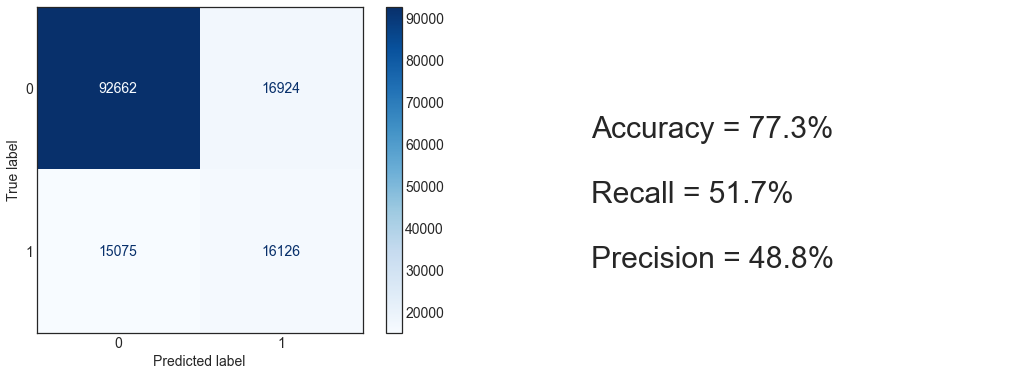

In [51]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_dtc_opt["y_true"], pred_dtc_opt["y_pred"]))
disp.plot(cmap="Blues", ax=ax1);
ax2 = fig.add_subplot(gs[0, 1])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
#
ax2.text(0.1, 0.6, 'Accuracy = '+ str(round(accuracy_score(pred_dtc_opt["y_true"],
                                                           pred_dtc_opt["y_pred"])*100, 1)) + "%",
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.4, 'Recall = '+ str(round(recall_score(pred_dtc_opt["y_true"], 
                                                       pred_dtc_opt["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.2, 'Precision = '+ str(round(precision_score(pred_dtc_opt["y_true"], 
                                                             pred_dtc_opt["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});

<div style="font-weight:700">Let's see what is happening if we use the class_weight = balanced parameter</div>

In [52]:
grid_DTC_opt = {'classifier': [DecisionTreeClassifier()],
                'classifier__criterion': ["gini", "entropy"],
                'classifier__splitter': ["best", "random"],
                'classifier__max_depth': stats.randint(1, 300),
                'classifier__min_samples_split': stats.randint(2, 30),
                'classifier__class_weight': ["balanced"],
                "preprocessor__scaler": [RobustScaler()]
                }

search_DTC_opt = RandomizedSearchCV(final_pipe,
                                    grid_DTC_opt,
                                    scoring="recall",
                                    n_iter=20,
                                    cv=5,
                                    n_jobs=-1,
                                    verbose=True)
search_DTC_opt.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [53]:
search_DTC_opt.best_params_

{'classifier': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                        max_depth=4, min_samples_split=24),
 'classifier__class_weight': 'balanced',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 4,
 'classifier__min_samples_split': 24,
 'classifier__splitter': 'best',
 'preprocessor__scaler': RobustScaler()}

In [54]:
search_DTC_opt.best_score_

0.7382754756593084

In [55]:
pred_dtc_opt_balanced = pd.DataFrame(y_train).copy()
pred_dtc_opt_balanced['predictions'] = cross_val_predict(estimator=search_DTC_opt.best_estimator_,
                                                         X=X_train,
                                                         y=y_train,
                                                         cv=5)
pred_dtc_opt_balanced.columns = ["y_true", "y_pred"]

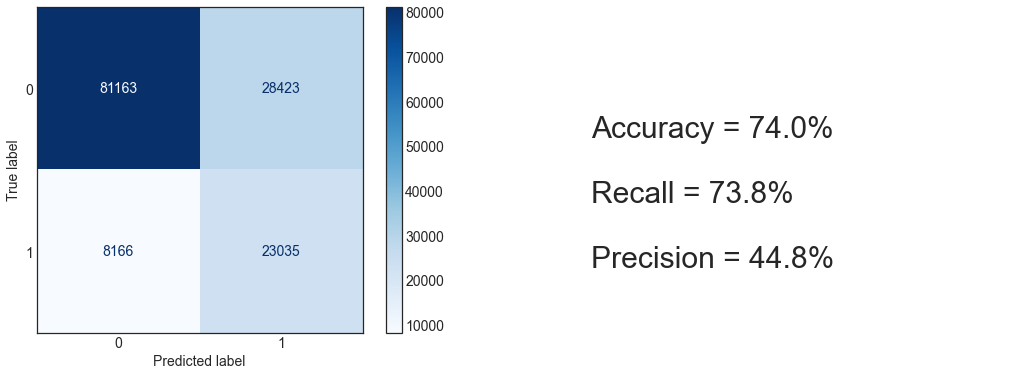

In [56]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_dtc_opt_balanced["y_true"], pred_dtc_opt_balanced["y_pred"]))
disp.plot(cmap="Blues", ax=ax1);
ax2 = fig.add_subplot(gs[0, 1])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
#
ax2.text(0.1, 0.6, 'Accuracy = '+ str(round(accuracy_score(pred_dtc_opt_balanced["y_true"],
                                                           pred_dtc_opt_balanced["y_pred"])*100, 1)) + "%",
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.4, 'Recall = '+ str(round(recall_score(pred_dtc_opt_balanced["y_true"], 
                                                       pred_dtc_opt_balanced["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.2, 'Precision = '+ str(round(precision_score(pred_dtc_opt_balanced["y_true"], 
                                                             pred_dtc_opt_balanced["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});

<div style="font-weight:700">Loosing a bit of accuracy but greatly increasing the recall score.</div>

## 7.3. Model Simplification
<br/>
<div style="font-weight:700">We remove features with low prediction score from permutation importance</div>

In [57]:
log_model = search_DTC_opt.best_estimator_.fit(X_train, y_train)

In [58]:
permutation_score = permutation_importance(log_model, X_train, y_train, n_repeats=50)

In [59]:
importance_df = pd.DataFrame(np.vstack((X_train.columns, permutation_score.importances_mean)).T)

In [60]:
importance_df.columns=['feature','score decrease']

In [61]:
importance_df.sort_values(by="score decrease", ascending = False)

feature score decrease
11    Humidity3pm       0.153498
5   WindGustSpeed       0.031143
0        Location            0.0
1         MinTemp            0.0
2         MaxTemp            0.0
3        Rainfall            0.0
4     WindGustDir            0.0
6      WindDir9am            0.0
7      WindDir3pm            0.0
8    WindSpeed9am            0.0
9    WindSpeed3pm            0.0
10    Humidity9am            0.0
12    Pressure9am            0.0
13        Temp9am            0.0
14      RainToday            0.0
15          Month            0.0

In [62]:
X_reduced = X_train[["Humidity3pm", "WindGustSpeed", "Location", "Pressure9am", "MinTemp"]]

In [63]:
cv_reduced_DTC = cross_validate(search_DTC_opt.best_estimator_, X_reduced, y_train, scoring= "recall", cv=2)
print("Reduced recall score for RandomForestClassifier: " + str(round(cv_reduced_DTC["test_score"].mean()*100, 2)) + "%")

Reduced recall score for RandomForestClassifier: 67.97%


In [64]:
pred_dtc_opt_reduced = pd.DataFrame(y_train).copy()
pred_dtc_opt_reduced['predictions'] = cross_val_predict(estimator=search_DTC_opt.best_estimator_,
                                                        X=X_reduced,
                                                        y=y_train,
                                                        cv=5)
pred_dtc_opt_reduced.columns = ["y_true", "y_pred"]

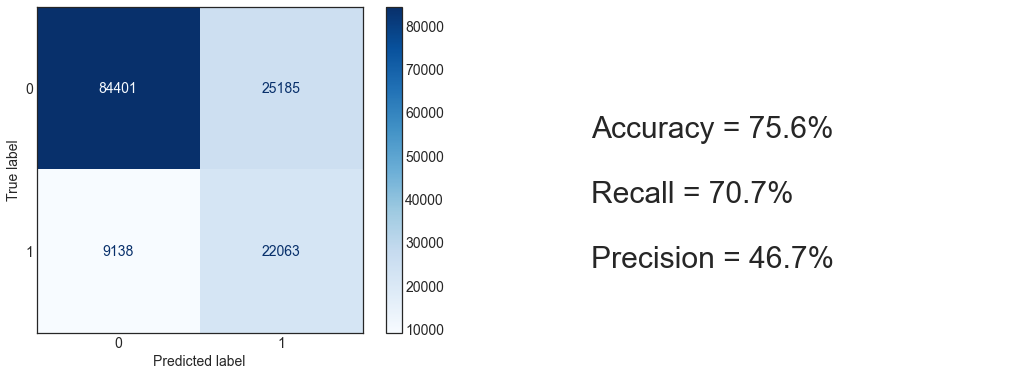

In [65]:
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_dtc_opt_reduced["y_true"], pred_dtc_opt_reduced["y_pred"]))
disp.plot(cmap="Blues", ax=ax1);
ax2 = fig.add_subplot(gs[0, 1])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
#
ax2.text(0.1, 0.6, 'Accuracy = '+ str(round(accuracy_score(pred_dtc_opt_reduced["y_true"],
                                                           pred_dtc_opt_reduced["y_pred"])*100, 1)) + "%",
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.4, 'Recall = '+ str(round(recall_score(pred_dtc_opt_reduced["y_true"], 
                                                       pred_dtc_opt_reduced["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});
#
ax2.text(0.1, 0.2, 'Precision = '+ str(round(precision_score(pred_dtc_opt_reduced["y_true"], 
                                                             pred_dtc_opt_reduced["y_pred"])*100, 1)) + "%", 
         fontdict= {"fontsize":30});

## 7.4. Undersampling Majority target class / Oversampling Minority target class

In [66]:
X_train_resampled = preprocessor.fit_transform(X_train)
pd.DataFrame(X_train_resampled).head()

0         1         2         3         4         5         6    \
0 -0.216609 -0.286366 -0.277606 -1.368479 -0.563718 -1.334057 -0.149090   
1 -1.327163 -0.595932 -0.277606 -1.216176 -1.580343 -0.875269  0.325579   
2 -0.404308 -1.046211 -0.277606  0.916061 -0.563718  0.157004 -1.784059   
3 -0.326100 -1.088424  1.683377  0.763758  0.339949  0.845186  1.433139   
4 -0.154042 -0.989926 -0.064969 -0.759268 -0.111885 -0.416481  1.063952   

        7         8         9         10        11        12       13   \
0 -0.167874  1.592111 -0.198596 -0.536378  6.754126 -0.147455 -0.14733   
1 -0.946580  0.969812 -1.139832 -0.536378  6.754126 -0.147455 -0.14733   
2 -0.021866  0.036363 -0.352897 -0.536378  6.754126 -0.147455 -0.14733   
3  1.389539 -1.519385 -0.892950  1.864356  6.754126 -0.147455 -0.14733   
4  0.902847  0.110447 -0.615209  1.864356  6.754126 -0.147455 -0.14733   

        14        15        16        17        18        19        20   \
0 -0.148183 -0.144435 -0.147982 -0.148308 -0.150839 -0.146649 -0.157361   
1 -0.148183 -0.144435 -0.147982 -0.148308 -0.150839 -0.146649 -0.157361   
2 -0.148183 -0.144435 -0.147982 -0.148308 -0.150839 -0.146649 -0.157361   
3 -0.148183 -0.144435 -0.147982 -0.148308 -0.150839 -0.146649 -0.157361   
4 -0.148183 -0.144435 -0.147982 -0.148308 -0.150839 -0.146649 -0.157361   

        21        22        23        24        25        26        27   \
0 -0.147053 -0.146041 -0.146016 -0.152311 -0.145635 -0.152091 -0.105337   
1 -0.147053 -0.146041 -0.146016 -0.152311 -0.145635 -0.152091 -0.105337   
2 -0.147053 -0.146041 -0.146016 -0.152311 -0.145635 -0.152091 -0.105337   
3 -0.147053 -0.146041 -0.146016 -0.152311 -0.145635 -0.152091 -0.105337   
4 -0.147053 -0.146041 -0.146016 -0.152311 -0.145635 -0.152091 -0.105337   

        28        29        30        31        32        33        34   \
0 -0.148058 -0.128815 -0.147782 -0.147681 -0.142215 -0.148108 -0.142864   
1 -0.148058 -0.128815 -0.147782 -0.147681 -0.142215 -0.148108 -0.142864   
2 -0.148058 -0.128815 -0.147782 -0.147681 -0.142215 -0.148108 -0.142864   
3 -0.148058 -0.128815 -0.147782 -0.147681 -0.142215 -0.148108 -0.142864   
4 -0.148058 -0.128815 -0.147782 -0.147681 -0.142215 -0.148108 -0.142864   

        35        36        37        38        39        40        41   \
0 -0.145762 -0.106024 -0.144716 -0.146143 -0.147455 -0.138399 -0.145304   
1 -0.145762 -0.106024 -0.144716 -0.146143 -0.147455 -0.138399 -0.145304   
2 -0.145762 -0.106024 -0.144716 -0.146143 -0.147455 -0.138399 -0.145304   
3 -0.145762 -0.106024 -0.144716 -0.146143 -0.147455 -0.138399 -0.145304   
4 -0.145762 -0.106024 -0.144716 -0.146143 -0.147455 -0.138399 -0.145304   

        42        43        44        45        46        47       48   \
0 -0.152335 -0.147782 -0.147153 -0.145176 -0.147355 -0.146066 -0.15567   
1 -0.152335 -0.147782 -0.147153 -0.145176 -0.147355 -0.146066 -0.15567   
2 -0.152335 -0.147782 -0.147153 -0.145176 -0.147355 -0.146066 -0.15567   
3 -0.152335 -0.147782 -0.147153 -0.145176 -0.147355 -0.146066 -0.15567   
4 -0.152335 -0.147782 -0.147153 -0.145176 -0.147355 -0.146066 -0.15567   

        49        50        51        52        53        54        55   \
0 -0.147581 -0.148233 -0.146522 -0.103844 -0.146497 -0.141669 -0.147304   
1 -0.147581 -0.148233 -0.146522 -0.103844 -0.146497 -0.141669 -0.147304   
2 -0.147581 -0.148233 -0.146522 -0.103844 -0.146497 -0.141669 -0.147304   
3 -0.147581 -0.148233 -0.146522 -0.103844 -0.146497 -0.141669 -0.147304   
4 -0.147581 -0.148233 -0.146522 -0.103844 -0.146497 -0.141669 -0.147304   

       56        57        58        59        60        61        62   \
0 -0.13102 -0.145635 -0.146117 -0.147153 -0.261095  4.094773 -0.232905   
1 -0.13102 -0.145635 -0.146117 -0.147153 -0.261095 -0.244214 -0.232905   
2 -0.13102 -0.145635 -0.146117 -0.147153 -0.261095 -0.244214 -0.232905   
3 -0.13102 -0.145635 -0.146117 -0.147153 -0.261095 -0.244214 -0.232905   
4 -0.13102 -0.145635 -0.146117 -0.147153 -

In [68]:
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imPipe

In [69]:
# Sampling strategies
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.7)

In [70]:
# Pipelining the two strategies
steps =  [('o', over), ('u', under)]
sampling_pipe = imPipe(steps=steps)


# Rebalance the dataset
X_resampled, y_resampled = sampling_pipe.fit_resample(X_train_resampled, y_train)

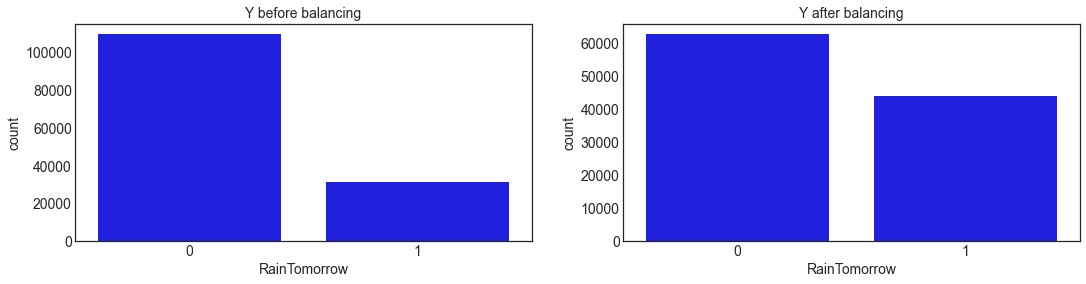

In [71]:
# plotting
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,4))

''' Before rebalancing classes'''

sns.countplot(y_train, ax=ax[0], color='b')
ax[0].set_title('Y before balancing', fontsize=14)

''' After rebalancing classes'''

sns.countplot(y_resampled, ax=ax[1], color='b')
ax[1].set_title('Y after balancing', fontsize=14);

In [72]:
resampled_classifier = DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=19,
                                              min_samples_split=7, 
                                              splitter='random', 
                                              criterion="gini")

In [73]:
cv_resampled = cross_validate(resampled_classifier, X_resampled, y_resampled, scoring= "recall", cv=10)
print("Resampled dataset recall score for DTC: " + str(round(cv_resampled["test_score"].mean()*100, 2)) + "%")

Resampled dataset recall score for DTC: 65.32%


In [74]:
cv_resampled = cross_validate(LogisticRegression(class_weight="balanced", max_iter=10000), X_resampled, y_resampled, scoring= "recall", cv=10)
print("Resampled dataset recall score for DTC: " + str(round(cv_resampled["test_score"].mean()*100, 2)) + "%")

Resampled dataset recall score for DTC: 61.43%


JOBLIB

In [1]:
import joblib
joblib.load("../models/model.joblib")

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('preproc',
                                                               ColumnTransformer(transformers=[('numeric',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x7fc5e6f06610>),
                                                                                               ('binary',
                                                                                                Pipeline(steps=[('encoder',
                                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                                               sparse=False))]),
                                                                                                <...
                                        'classifier__class_weight': ['balanced',
                                                                     'none'],
                                        'classifier__penalty': ['l1', 'l2'],
                                        'classifier__solver': ['liblinear',
                                                               'sag', 'saga'],
                                        'classifier__tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc5e6ef3ca0>,
                                        'preprocessor__preproc__numeric__imputer__strategy': ['mean',
                                                                                              'median'],
                                        'preprocessor__scaler': [StandardScaler(),
                                                                 RobustScaler(),
                                                                 MinMaxScaler()]},
                   scoring='recall')